# Exploratory Data Analysis 📁

In [2]:
import pandas as pd 
from dotenv import load_dotenv
import requests

In [ ]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join("..", "src")))
from utils_eda import graphic_time_series, levene_test, acf_plot, pacf_plot, adf_test, stl_plot

## Data Loading

In [12]:
def get_noaa_data(token, datasetid, stationid, startdate, enddate, datatypeid):
    """ 
    Uses NOAA's API to retrieve climate data based on given parameters.
    Returns JSON data if successful.
    """
    url = "https://www.ncei.noaa.gov/cdo-web/api/v2/data"
    headers = {"token": token}
    params = {
        "datasetid": datasetid,
        "stationid": stationid,
        "startdate": startdate,
        "enddate": enddate,
        "datatypeid": datatypeid,
        "limit": 1000,
        "units": "metric"
    }

    response = requests.get(url, headers=headers, params=params)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code}")
        print(response.text)
        return None

In [ ]:
# Get token
load_dotenv()
token = os.getenv("NOAA_TOKEN")

data = get_noaa_data(
    token=token,
    datasetid="GSOM",
    stationid="GHCND:USW00014989",
    startdate="2017-01-01",
    enddate="2024-12-31",
    datatypeid="TAVG"
)

In [ ]:
results = data.get("results", [])
df = pd.DataFrame(results)
df["date"] = pd.to_datetime(df["date"])
df["value"] = df["value"]/10
df.to_parquet("../Data/raw_data.parquet")

## Data Overview

In [ ]:
df = pd.read_parquet("../Data/raw_data.parquet")
print(df.shape)
df.info()

(90, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        90 non-null     datetime64[ns]
 1   datatype    90 non-null     object        
 2   station     90 non-null     object        
 3   attributes  90 non-null     object        
 4   value       90 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 3.6+ KB


In [ ]:
df.describe()

,date,value
count,90,90.000000
mean,2021-02-09 19:28:00,1.082778
min,2017-02-01 00:00:00,-0.790000
25%,2019-03-08 18:00:00,0.247500
50%,2021-03-16 12:00:00,1.040000
75%,2023-01-24 06:00:00,2.087500
max,2024-12-01 00:00:00,2.440000
std,NaN,0.980021


## Data Cleaning

In [ ]:
df = df.sort_values("date")

In [ ]:
df.set_index("date", inplace=True)

In [ ]:
df.isnull().sum()
df[df.isnull().any(axis=1)]

,datatype,station,attributes,value
date,,,,


In [ ]:
df = df["value"]*10

In [ ]:
df.rename("AverageTemperature")

date
2017-02-01     4.7
2017-03-01     6.1
2017-04-01    10.6
2017-05-01    15.9
2017-06-01    23.0
              ... 
2024-08-01    21.4
2024-09-01    19.9
2024-10-01    14.5
2024-11-01     5.3
2024-12-01     0.0
Name: AverageTemperature, Length: 90, dtype: float64

In [ ]:
df = df.to_frame()
df.to_parquet("../Data/clean_data.parquet")


## Univariate Analysis

In [3]:
serie = pd.read_parquet("../Data/clean_data.parquet")
serie = pd.Series(serie["value"], name="AverageTemperature")
serie.sample(5)

date
2021-09-01    20.0
2020-05-01    14.8
2023-09-01    20.5
2020-11-01     6.5
2022-03-01     3.9
Name: AverageTemperature, dtype: float64

In [3]:
serie.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 90 entries, 2017-02-01 to 2024-12-01
Series name: AverageTemperature
Non-Null Count  Dtype  
--------------  -----  
90 non-null     float64
dtypes: float64(1)
memory usage: 1.4 KB


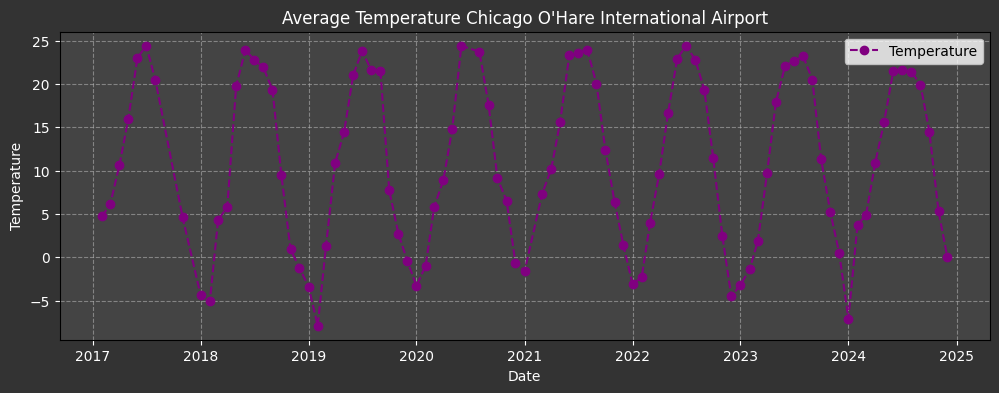

In [4]:
graphic_time_series(
    serie=serie, 
    title="Average Temperature Chicago O'Hare International Airport", 
    path='../Outputs/Figures/time_serie',
    ylabel='Temperature'
)

In [5]:
stats_levene, p_value_levene = levene_test(serie=serie, freq='6ME', min_group_size=5)

Levene's test statistic: 0.0441, p-value: 1.0000
✅ HOMOSCEDASTICITY confirmed: variance is stable across time.


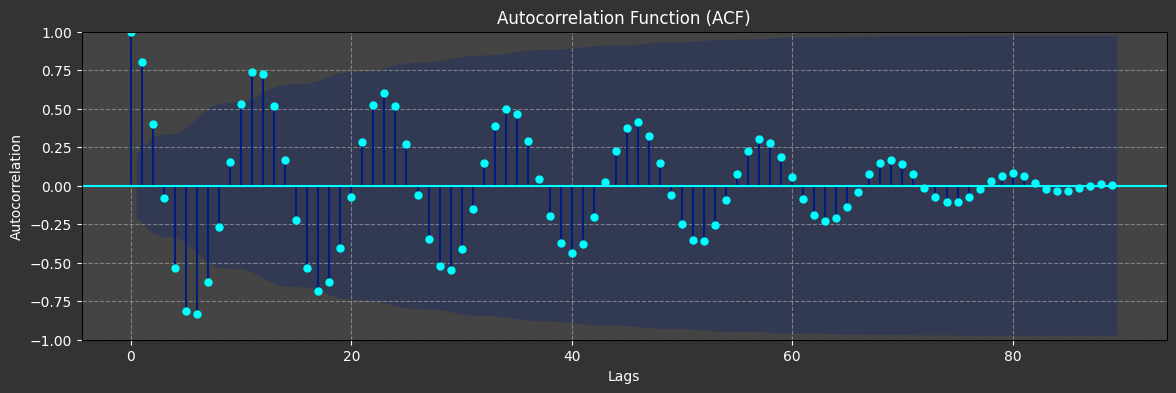

In [6]:
acf_plot(
    serie=serie, 
    lags=89,
    name="Autocorrelation Function (ACF)",
    path="../Outputs/Figures/autocorrelation_function" 
)

In [7]:
stats_adf, p_value_adf, critic_vals_adf = adf_test(serie, name="Average Temperature")

ADF Test for 'Average Temperature':
  Test Statistic: -8.9149
  p-value       : 0.0000
  Critical Values:
    1%: -3.5097
    5%: -2.8962
    10%: -2.5853
✅ STATIONARY: The time series is stationary (reject H0).


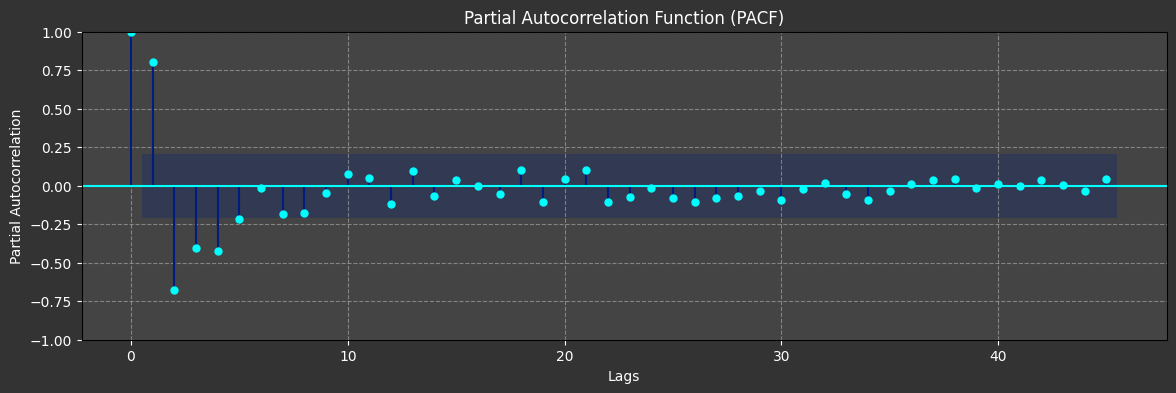

In [8]:
pacf_plot(
    serie=serie,
    lags=45,
    name="Partial Autocorrelation Function (PACF)",
    path="../Outputs/Figures/partial_autocorrelation_function"
)

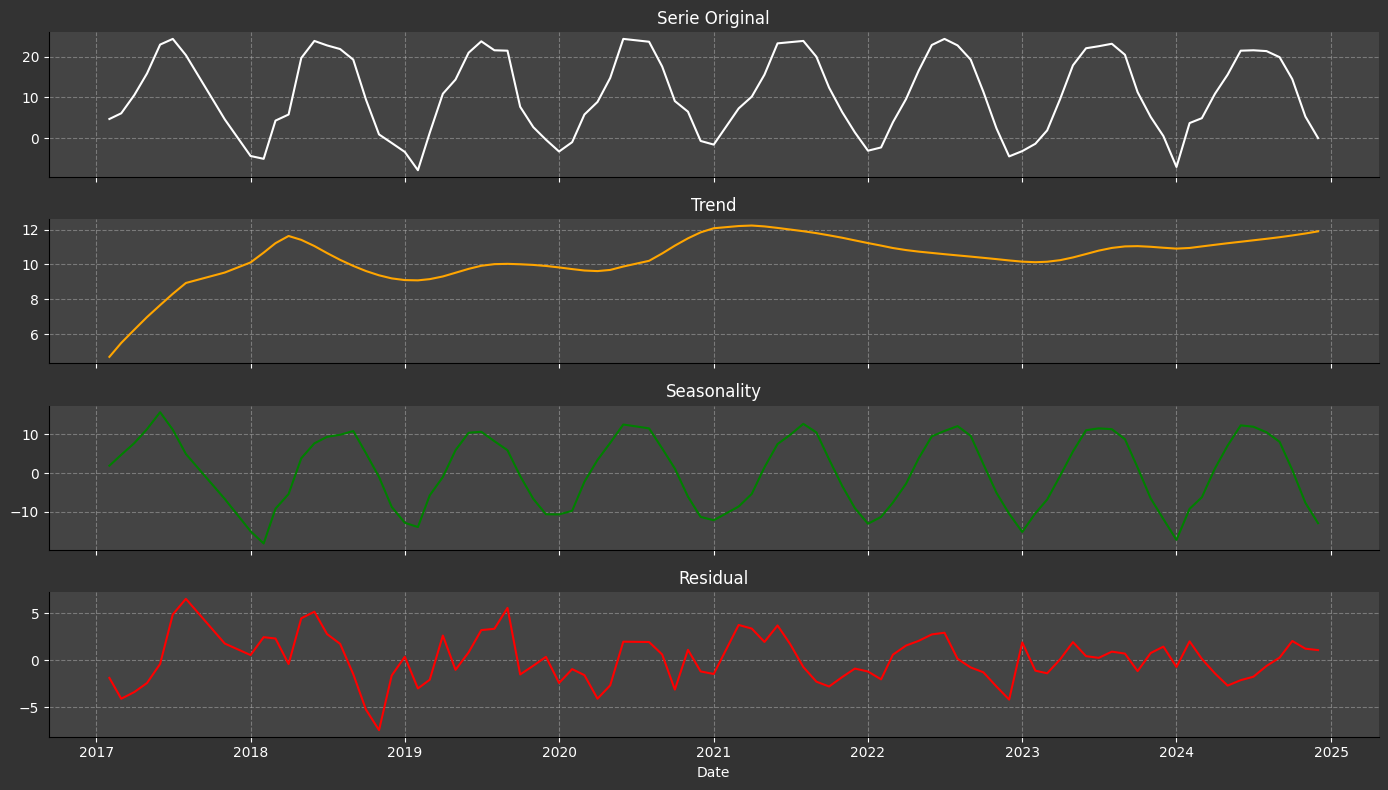

In [9]:
stl_plot(
    serie=serie,
    path="../Outputs/Figures/stl_decomposition",
    name="Serie Original",
    period=12
)

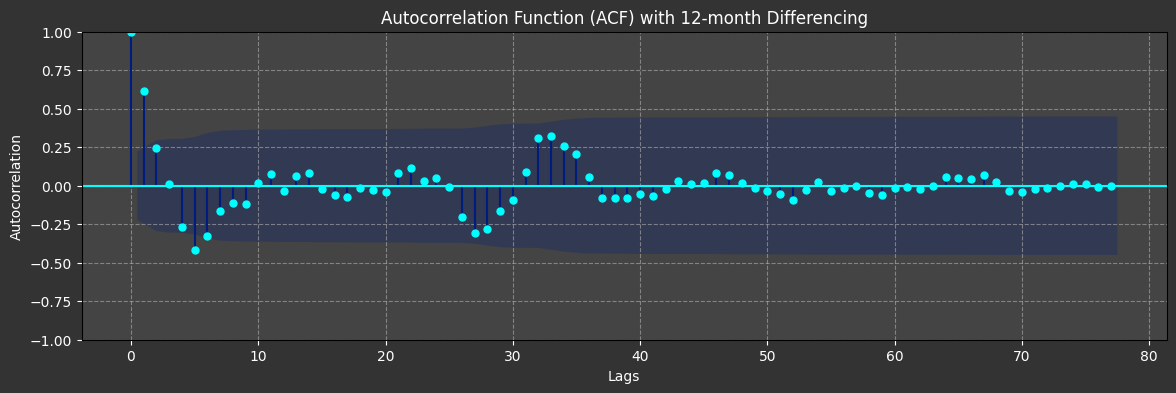

In [10]:
serie_diff_12 = serie.diff(12).dropna()

acf_plot(
    serie=serie_diff_12,
    lags=77,
    name="Autocorrelation Function (ACF) with 12-month Differencing",
    path="../Outputs/Figures/autocorrelation_function_with_12-month_differencing"
)

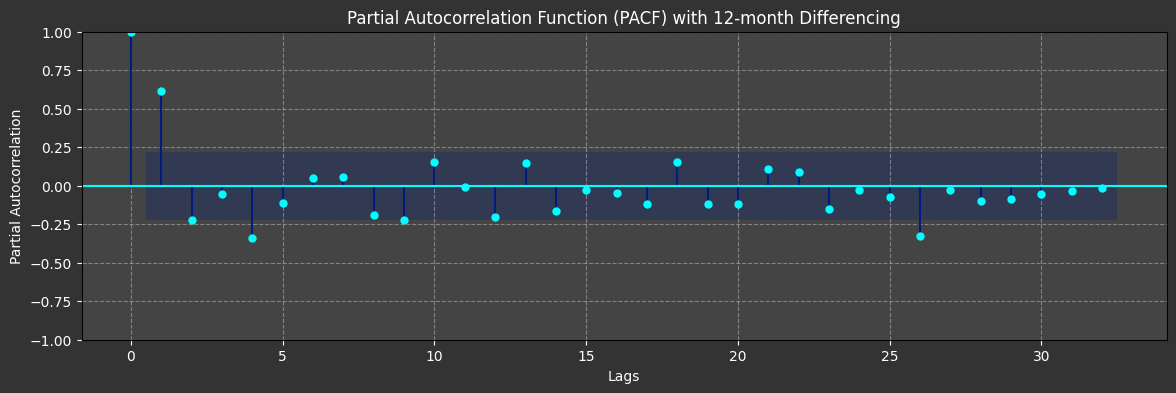

In [11]:
pacf_plot(
    serie=serie_diff_12,
    lags=32,
    name="Partial Autocorrelation Function (PACF) with 12-month Differencing",
    path="../Outputs/Figures/partial_autocorrelation_function_with_12-month_differencing"
)

## Report

In [12]:
%pip install tabulate

import sys
import os
sys.path.append(os.path.abspath("../src"))
from generate_report import render_report

context = {
    "station_id": "GHCND:MXM00076679",
    "start_date": "2005-01-01",
    "end_date": "2024-12-31",
    "summary_stats": serie.describe().to_markdown(),
    "levene_stat": round(stats_levene, 3),
    "levene_pval": round(p_value_levene, 3),
    "adf_stat": round(stats_adf, 3),
    "adf_pval": round(p_value_adf, 3),
    "adf_crit_vals": '\n'.join([f"{k}: {v:.3f}" for k, v in critic_vals_adf.items()]),
    "conclusion": "seasonal trends and moderate stationarity after differencing",
}

render_report(context)

Note: you may need to restart the kernel to use updated packages.
✅ Report saved to ../Reports/EDA_Report.md


## Models

### Analysis after seasonal differencing (D=1, lag 12)

*   The ACF gradually decreases, with significant values at the first non-seasonal lags, indicating a possible AR process and some MA component.

*   The PACF shows strong significance at lags 1 and 2, then quickly drops off, suggesting that a non-seasonal AR(1) or AR(2) model is sufficient.

*   At seasonal lags (multiples of 12), no significant peaks appear in either the ACF or PACF, indicating there is no clear evidence for a seasonal AR component (P=0).

*   However, the seasonality is being captured by the seasonal differencing (D=1), which removes the repeating pattern to make the series stationary

### Therefore, the recommended SARIMA model structure is:
*   Non-seasonal part: (p=1, d=0, q=1) or simpler models based on results.

*   Seasonal part: (P=0, D=1, Q=0) with seasonal period 12.

### Suggested models to try:
*   $SARIMA(1,0,1)(0,1,0)_{12}$

*   $SARIMA(1,0,0)(0,1,0)_{12}$

*   $SARIMA(0,0,1)(0,1,0)_{12}$